In [1]:
from net.parse import *
from net import *

In [2]:
DELTA = 3
CONTEXT = 10

In [3]:
# Build dataset
trends = merge_on_date(parse_path(Path('../data/trends'))) # Parse trends data
stats = get_data() # Parse stats data
x_train, y_train, x_test, y_test, mean, std = build_data(trends, stats, DELTA, CONTEXT)

/Users/tudor/CS-Work/ML/P3/VFNN/src/net/parse/finance_parser.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  daily = yf.download(tickers='^SPX', start=start, end=end, interval='1d')
[*********************100%***********************]  1 of 1 completed


In [ ]:
# Model Hyperparameters
HIDDEN = 32
INPUT_SIZE = 28 # Fixed
MLP_SIZE = (32, 1) # Has to end in 1
BATCH_SIZE = 32
STEPS = 20000
LR = 1e-3
LAMBDA_ = 1e-4

In [5]:
# Initialize
model = VFNN(HIDDEN, INPUT_SIZE, MLP_SIZE)

In [6]:

def hybrid_loss(preds, targets, alpha=0.7):
    return alpha * MAPE(preds, targets, mean[:, -2], std[:, -2]) + (1 - alpha) * RMSE(preds, targets)

Loss: 212.94186401367188 on step: 1
Loss: 31.876340866088867 on step: 101
Loss: 50.281681060791016 on step: 201
Loss: 36.623268127441406 on step: 301
Loss: 41.138912200927734 on step: 401
Loss: 31.799623489379883 on step: 501
Loss: 29.86665153503418 on step: 601
Loss: 33.977203369140625 on step: 701
Loss: 30.6757755279541 on step: 801
Loss: 25.90070915222168 on step: 901
Loss: 28.453805923461914 on step: 1001
Loss: 27.351903915405273 on step: 1101
Loss: 20.282623291015625 on step: 1201
Loss: 27.485126495361328 on step: 1301
Loss: 32.60673141479492 on step: 1401
Loss: 20.432504653930664 on step: 1501
Loss: 19.398147583007812 on step: 1601
Loss: 9.697537422180176 on step: 1701
Loss: 14.582720756530762 on step: 1801
Loss: 10.419876098632812 on step: 1901
Loss: 10.71351432800293 on step: 2001
Loss: 11.556869506835938 on step: 2101
Loss: 6.187468528747559 on step: 2201
Loss: 7.103599548339844 on step: 2301
Loss: 14.072336196899414 on step: 2401
Loss: 12.626518249511719 on step: 2501
Loss: 1

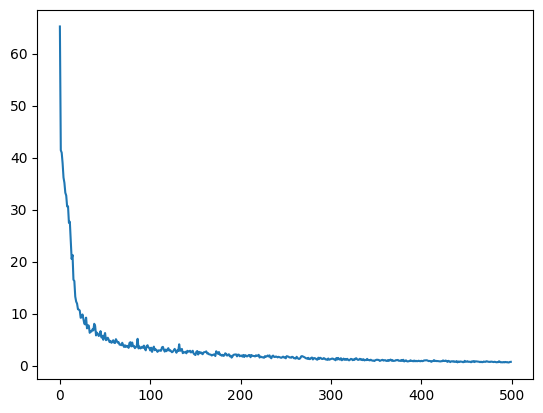

In [7]:
# Train
model.train()
lossi = adam(model, lambda x, y: MAPE(x, y, mean[:, -2], std[:, -2]), x_train, y_train, LR, LAMBDA_, BATCH_SIZE, STEPS)

# Plot loss
from matplotlib import pyplot as plt
plt.plot(torch.tensor(lossi).view(-1, 100).mean(1))

In [36]:
def MAPE(y_pred, y_true):
    """
    Symmetric mean absolute percentage error
    """
    return 100 * torch.mean(torch.abs(y_pred - y_true) / (torch.abs(y_true)))

def smape(y_true, y_pred):
    return 100 * torch.mean(2 * torch.abs(y_pred - y_true) / (torch.abs(y_pred) + torch.abs(y_true) + 1e-8))

In [37]:
model.eval()
vals = model.forward(x_train)
percents = (vals.flatten() * std[:, -2] + mean[:, -2]) / 1e4
targs = (y_train.flatten() * std[:, -2] + mean[:, -2]) / 1e4
loss = RMSE(percents, targs)
print(loss.item())
print(smape(percents, targs).item())

0.010750378482043743
0.8614141345024109


In [38]:
model.eval()
vals = model.forward(x_test)
percents = (vals.flatten() * std[:, -2] + mean[:, -2]) / 1e4
targs = (y_test.flatten() * std[:, -2] + mean[:, -2]) / 1e4
loss = RMSE(percents, targs)
print(loss.item())
print(smape(percents, targs).item())

0.0007663648575544357
25.45657730102539


Text(0.5, 1.0, 'Target Distribution (Unnormalized)')

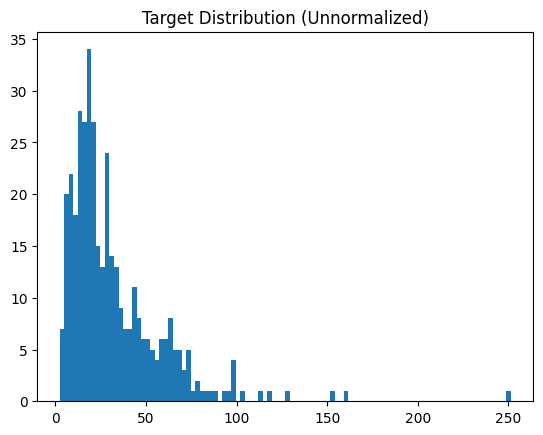

In [39]:
plt.hist((targs * 1e4).numpy(), bins=100)
plt.title("Target Distribution (Unnormalized)")


Text(0.5, 1.0, 'Percent Distribution (Unnormalized)')

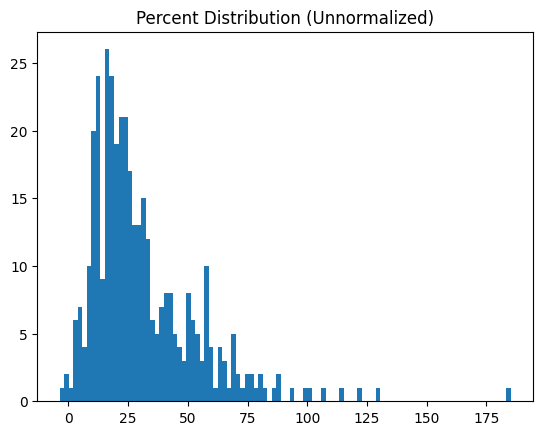

In [40]:
plt.hist((percents*1e4).detach().numpy(), bins=100)
plt.title("Percent Distribution (Unnormalized)")

Text(0, 0.5, 'Absolute Error')

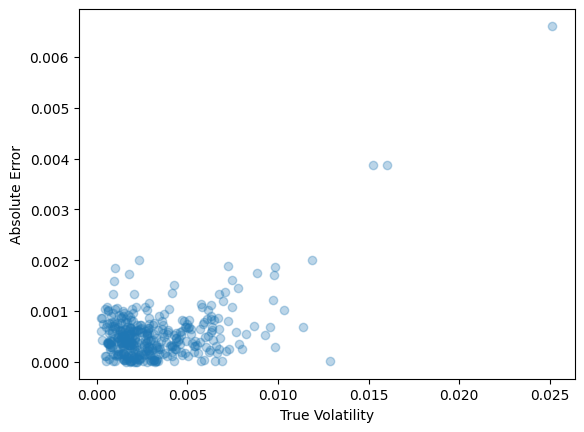

In [41]:
plt.scatter(targs.numpy(), (percents.detach() - targs).abs().numpy(), alpha=0.3)
plt.xlabel("True Volatility")
plt.ylabel("Absolute Error")


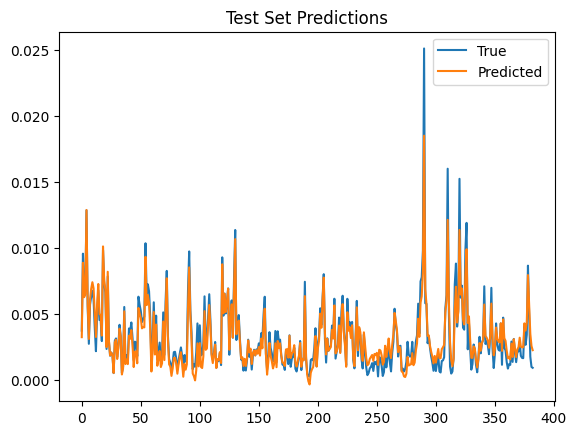

In [42]:
plt.plot(targs.detach(), label="True")
plt.plot(percents.detach(), label="Predicted")
plt.title("Test Set Predictions")
plt.legend()
